# Exploring the Carrada Dataset

This notebook provides a comprehensive exploration of the Carrada dataset. It covers:

- **Dataset Structure:** Overview of data types, available sequences, and annotations.
- **Data Loading:** How to load and parse the dataset using provided dataloaders.
- **Visualizations:** 
  - Raw radar representations (Range Doppler, Range Angle, and Angle Doppler).
  - Data augmentations (horizontal and vertical flips).
  - Detailed segmentation masks where each channel represents a different class (e.g., background, vehicle, pedestrian, cyclist).
  - Histograms, legends, and overlays to aid in understanding the data.
- **Explanatory Frames:** Sample frames with multiple objects and annotations.

**Note:** Make sure that your paths and configuration file (`config_mac_mvrecord_carrada.yaml`) are correctly set up before running this notebook.


 ## Setup and Imports
 
 First, we import necessary libraries and modules. Make sure that the dataset, configuration, and custom modules (Carrada, SequenceCarradaDataset, CarradaDataset, HFlip, VFlip) are accessible via the Python path.


In [7]:
import os
import yaml
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from pathlib import Path

In [21]:
import sys
path_base = Path().resolve().parent
# Adjust this path to the root of your radar_sort package
sys.path.append(str(path_base))
path_base

PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort')

In [23]:
# Import custom dataset and dataloader classes

from data.carrada.dataset import Carrada
from data.carrada.dataloaders import SequenceCarradaDataset, CarradaDataset, HFlip, VFlip
from torch.utils.data import DataLoader
from utils.paths_internal import CONFIG_DIR

In [24]:
# Set configuration path and config file name
CONFIG_PTH = CONFIG_DIR
config_file = 'config_mac_mvrecord_carrada.yaml'

 ## Load Configuration and Dataset
 
 We load the configuration file (YAML format) which includes the dataset paths and parameters. Then we use the `Carrada` class to load the training split.


In [30]:
# Load the configuration file
config_path = os.path.join(CONFIG_PTH, 'carrada', config_file)
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load dataset from the training split
dataset = Carrada(config).get('Train')
print("Total sequences in Train split:", len(dataset.keys()))
# Show first 5 sequence keys
print("Available sequences:", list(dataset.keys())[:5])

Total sequences in Train split: 18
Available sequences: ['2019-09-16-12-52-12', '2019-09-16-12-55-51', '2019-09-16-12-58-42', '2019-09-16-13-03-38', '2019-09-16-13-11-12']


## Understanding the Data Structure

The Carrada dataset consists of:

- **Radar Representations:**
  - **Range Doppler (RD):** Represents radar return strength over time.
  - **Range Angle (RA):** Encodes angular information.
  - **Angle Doppler (AD):** Additional representation (if available).

- **Segmentation Masks:**
  - Provided as multi-channel arrays where each channel corresponds to a different semantic class.
  - For example, a mask of shape `(4, 256, 64)` implies four classes (commonly: background, vehicle, pedestrian, cyclist).

- **Frame Sequences:**
  - Each sequence contains multiple frames. The dataset loader is designed to load a sub-sequence of frames (e.g., the last `n_frames`) for a sample.

We now load a single sequence and inspect its content.



In [35]:
# Set target sequence and number of frames
# You can choose a specific key if desired
target_seq = list(dataset.keys())[0]
target_seq = '2019-09-16-12-55-51'
# Check the selected sequence
print("Selected sequence:", target_seq)

n_frames = 500



Selected sequence: 2019-09-16-12-55-51


### Create Sequence and Frame Dataloaders

We use a sequence-level dataloader (`SequenceCarradaDataset`) and a frame-level dataloader (`CarradaDataset`) to load the data for the selected sequence.

### Create Dataloaders for the Sequence and Frames
 
We first create a sequence-level dataloader and then a frame-level dataloader with deterministic (non-random) transformations.


In [36]:
# Create dataloader for just our target sequence
seq_dataloader = DataLoader(
    SequenceCarradaDataset({target_seq: dataset[target_seq]}),
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Get the sequence name and sequence data
seq_name, seq = next(iter(seq_dataloader))
path_to_frames = os.path.join(config['dataset_cfg']['carrada'], seq_name[0])
print("Sequence name:", seq_name[0])
print("Number of frames in sequence:", len(seq))

# Create dataloader for frames in the sequence using CarradaDataset (dense annotations)
frame_dataloader = DataLoader(
    CarradaDataset(seq, 'dense', path_to_frames,
                   process_signal=True, n_frames=n_frames),
    shuffle=False,
    batch_size=1,
    num_workers=0
)

Sequence name: 2019-09-16-12-55-51
Number of frames in sequence: 627


### Retrieve a Sample

We extract a sample that includes:
- **rd_matrix:** Range Doppler data with shape `[n_frames, H, W]`
- **rd_mask:** Multi-channel segmentation mask with shape `[n_classes, H, W]`
- **ra_matrix:** Range Angle data
- **ra_mask:** Range Angle mask (may be multi-channel or single-channel)

We then print the shapes to confirm the structure.

In [38]:
# Get sample data
sample = next(iter(frame_dataloader))

# Extract first sample from batch and convert to numpy arrays
rd_matrix = sample['rd_matrix'][0].cpu().numpy()  # Shape: [n_frames, H, W]
# Expected shape: [n_classes, H, W]
rd_mask = sample['rd_mask'][0].cpu().numpy()
ra_matrix = sample['ra_matrix'][0].cpu().numpy()
ra_mask = sample['ra_mask'][0].cpu().numpy()

print("RD matrix shape:", rd_matrix.shape)
print("RD mask shape (expected multi-channel):", rd_mask.shape)
print("RA matrix shape:", ra_matrix.shape)
print("RA mask shape:", ra_mask.shape)

RD matrix shape: (500, 256, 64)
RD mask shape (expected multi-channel): (4, 256, 64)
RA matrix shape: (500, 256, 256)
RA mask shape: (4, 256, 256)


## Visualizations

Next, we visualize the loaded data. We define a color mapping for segmentation classes:

- **Class Colors:**  
  Each channel in the segmentation mask represents a different semantic class (for example, 0 for background, 1 for vehicles, etc.).

We'll demonstrate the following visualizations:

1. **Raw RD and RA Matrices:** Show the last frame of these matrices.
2. **Data Augmentation:** Compare original RD with horizontally and vertically flipped versions.
3. **Segmentation Masks Overlay:** Overlay each channel (class) of the RD mask with its corresponding color.
4. **Individual Class Masks:** Plot each channel separately.
5. **Pixel Intensity Histogram:** Understand the distribution of intensities in the RD matrix.
6. **Multiple Object Frames:** Loop through several frames to highlight changes across time.


### Define Class Colors and Colormap

Each channel in the segmentation mask corresponds to a class. Adjust the dictionary below based on your dataset annotation scheme.

In [39]:
class_colors = {
    0: 'black',  # Background
    1: 'red',    # Class 1 (e.g., vehicle)
    2: 'blue',   # Class 2 (e.g., pedestrian)
    3: 'green'   # Class 3 (e.g., cyclist)
}
# Create a colormap for segmentation overlay using the class colors (ordered by class index)
cmap_seg = ListedColormap([class_colors[k]
                          for k in sorted(class_colors.keys())])

### Data Augmentation Visualization

We apply horizontal and vertical flips to see how the data augmentation transforms the input.

Text(0.5, 1.0, 'RA Matrix (Original)')

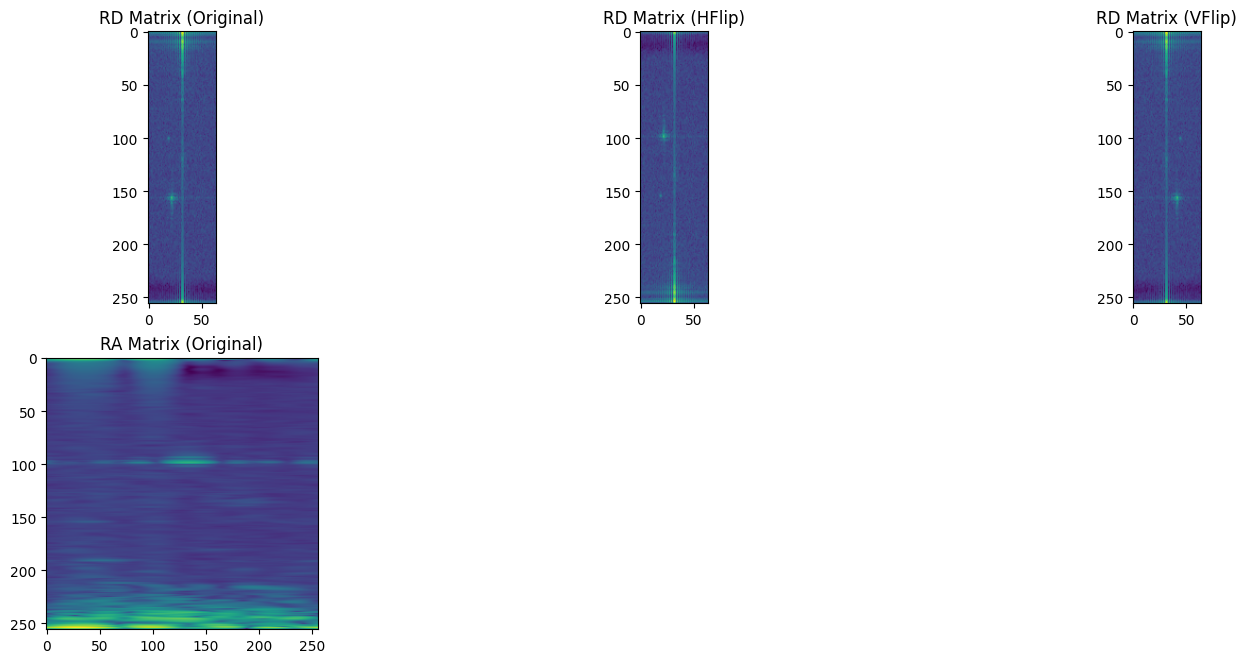

In [40]:
# Prepare original and augmented RD sample for visualization
original_rd = {'matrix': rd_matrix, 'mask': rd_mask}
hflip_rd = HFlip()(original_rd.copy())
vflip_rd = VFlip()(original_rd.copy())

plt.figure(figsize=(18, 12))

# Raw RD matrix (last frame)
plt.subplot(3, 3, 1)
plt.imshow(original_rd['matrix'][-1].squeeze(), cmap='viridis')
plt.title('RD Matrix (Original)')

# Horizontally flipped RD matrix
plt.subplot(3, 3, 2)
plt.imshow(hflip_rd['matrix'][-1].squeeze(), cmap='viridis')
plt.title('RD Matrix (HFlip)')

# Vertically flipped RD matrix
plt.subplot(3, 3, 3)
plt.imshow(vflip_rd['matrix'][-1].squeeze(), cmap='viridis')
plt.title('RD Matrix (VFlip)')

# Raw RA matrix (last frame)
plt.subplot(3, 3, 4)
plt.imshow(ra_matrix[-1].squeeze(), cmap='viridis')
plt.title('RA Matrix (Original)')

### Overlay of Segmentation Masks

The RD segmentation mask is multi-channel, with each channel representing a class. We overlay these channels on an RGB canvas.

**Notes in the Code:**
- Each channel (axis 0) of `rd_mask` corresponds to a semantic class.
- We use the corresponding color from `class_colors` for each class.
- The overlay is computed by summing the color contributions from each channel.

Text(0.5, 1.0, 'RD Mask (Multi-Class Overlay)')

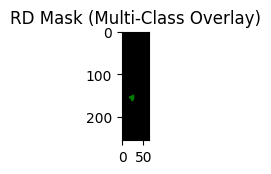

In [42]:
plt.subplot(3, 3, 5)
H, W = rd_mask.shape[1:]
combined_mask = np.zeros((H, W, 3))
for class_idx in range(rd_mask.shape[0]):
    # Each channel is a binary mask for a class
    class_mask = rd_mask[class_idx]
    # Get the RGB color for this class (first three channels of RGBA)
    color = np.array(plt.get_cmap(cmap_seg)(class_idx)[:3])
    # Add contribution of this class mask to the RGB image
    combined_mask += np.stack([class_mask] * 3, axis=-1) * color
plt.imshow(combined_mask)
plt.title('RD Mask (Multi-Class Overlay)')

### Visualize Each Class Mask Separately

Here, we plot each channel of the RD mask independently to understand the spatial distribution of each class.

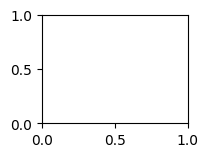

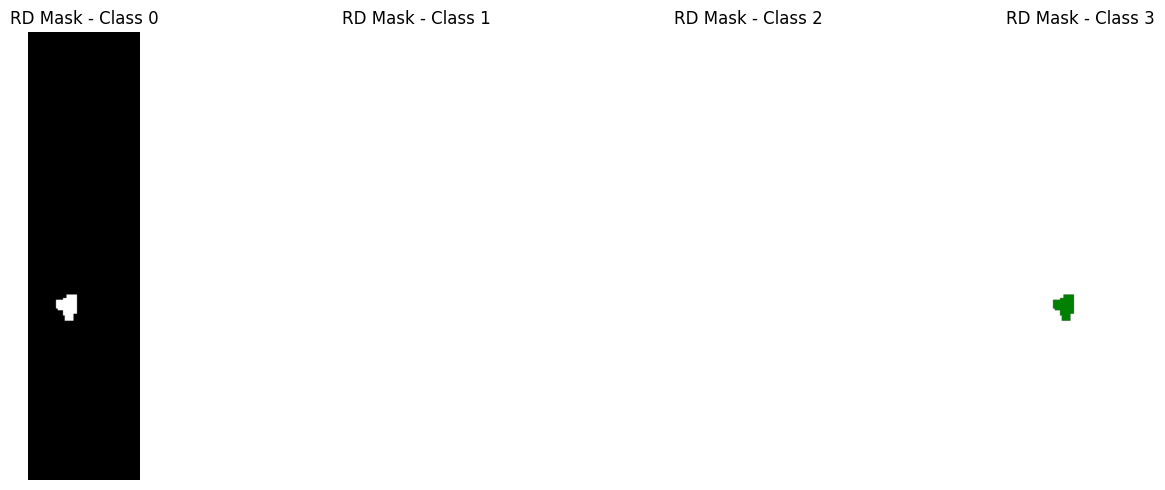

In [52]:
plt.subplot(3, 3, 6)
n_classes = rd_mask.shape[0]
fig, axes = plt.subplots(1, n_classes, figsize=(15, 5))
for i in range(n_classes):
    axes[i].imshow(np.ma.masked_where(rd_mask[i].squeeze() == 0,
                                      rd_mask[i].squeeze()),
                   cmap=ListedColormap([class_colors[i]]))
    axes[i].set_title(f'RD Mask - Class {i}')
    axes[i].axis('off')
plt.tight_layout()

### Histogram of RD Pixel Intensities

We compute a histogram of the pixel intensities from the last frame of the RD matrix to understand its dynamic range.

Text(0, 0.5, 'Frequency')

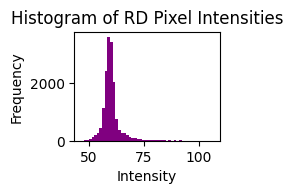

In [53]:
plt.subplot(3, 3, 7)
plt.hist(original_rd['matrix'][-1].ravel(), bins=50, color='purple')
plt.title('Histogram of RD Pixel Intensities')
plt.xlabel('Intensity')
plt.ylabel('Frequency')

### Legend for Segmentation Classes

We display a legend with the color mapping used for each segmentation class.

Text(0.5, 1.0, 'Segmentation Classes Legend')

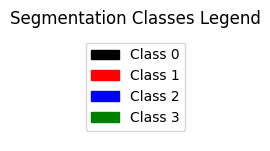

In [54]:
plt.subplot(3, 3, 8)
handles = [mpatches.Patch(
    color=class_colors[k], label=f'Class {k}') for k in sorted(class_colors.keys())]
plt.legend(handles=handles, loc='center')
plt.axis('off')
plt.title('Segmentation Classes Legend')

### Visualize Multiple Frames with Rich Annotations

Let’s loop through several frames in the sequence to see how objects and annotations evolve over time. Here we plot a grid of frames (showing the RD matrix with its segmentation overlay).


Processing class 0
Class mask shape: (256, 64)
Class color: [0. 0. 0.]
Max value in class mask: 1.0

Processing class 1
Class mask shape: (256, 64)
Class color: [1. 0. 0.]
Max value in class mask: 0.0

Processing class 2
Class mask shape: (256, 64)
Class color: [0. 0. 1.]
Max value in class mask: 0.0

Processing class 3
Class mask shape: (256, 64)
Class color: [0.         0.50196078 0.        ]
Max value in class mask: 1.0

Processing class 0
Class mask shape: (256, 64)
Class color: [0. 0. 0.]
Max value in class mask: 1.0

Processing class 1
Class mask shape: (256, 64)
Class color: [1. 0. 0.]
Max value in class mask: 0.0

Processing class 2
Class mask shape: (256, 64)
Class color: [0. 0. 1.]
Max value in class mask: 0.0

Processing class 3
Class mask shape: (256, 64)
Class color: [0.         0.50196078 0.        ]
Max value in class mask: 1.0

Processing class 0
Class mask shape: (256, 64)
Class color: [0. 0. 0.]
Max value in class mask: 1.0

Processing class 1
Class mask shape: (256,

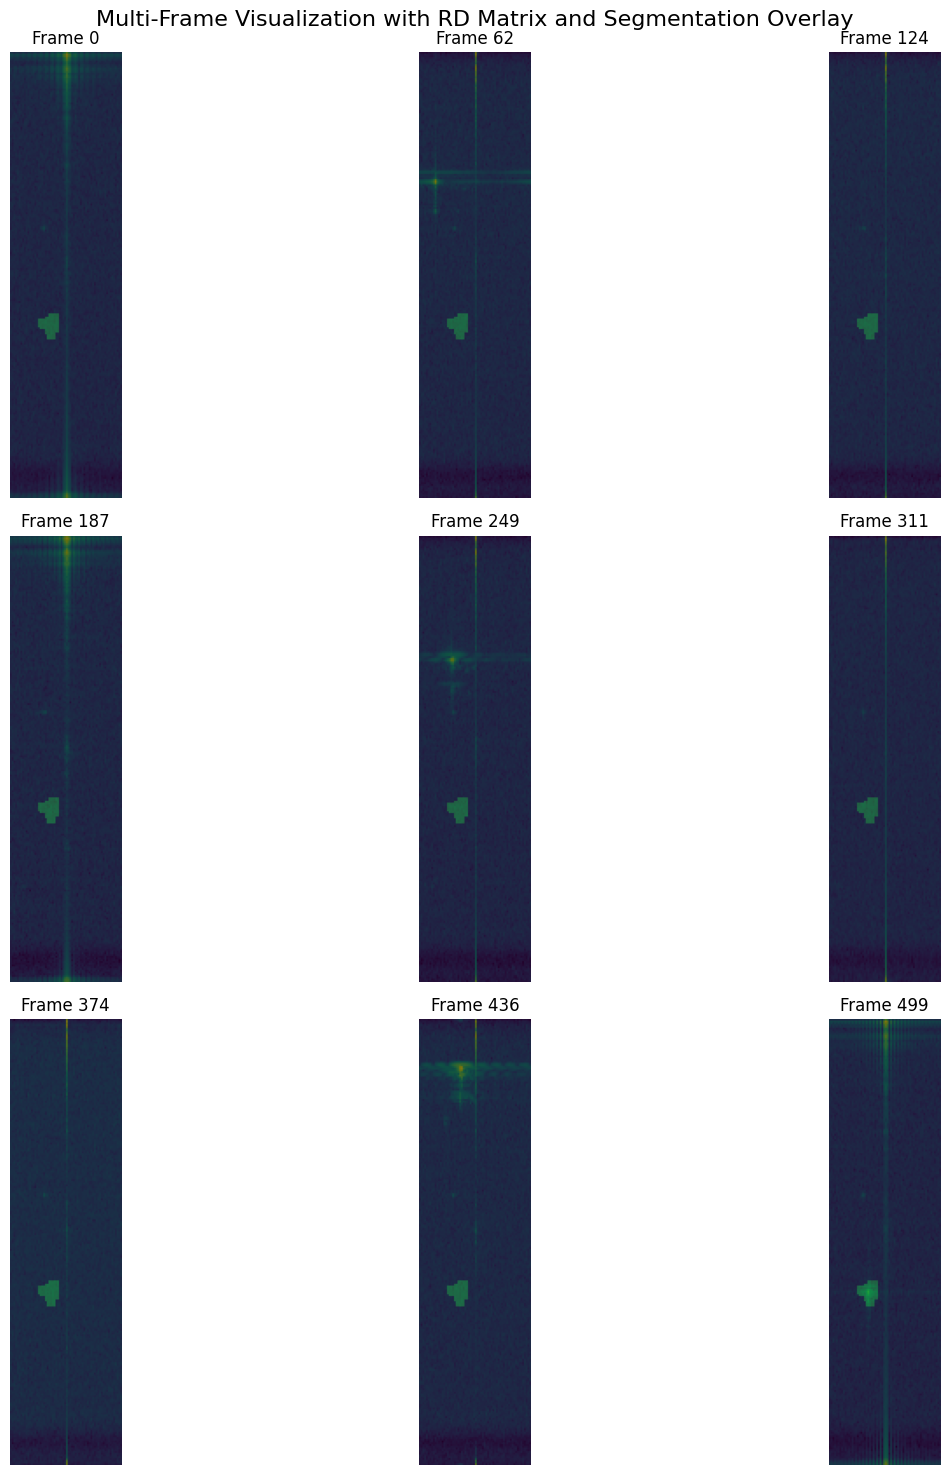

In [66]:
n_sample_frames = 9  # Number of frames to sample for multi-frame visualization
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
frame_indices = np.linspace(
    0, rd_matrix.shape[0]-1, n_sample_frames, dtype=int)

for idx, ax in zip(frame_indices, axes.flatten()):
    # Overlay segmentation for current frame
    combined_frame_mask = np.zeros((rd_mask.shape[1], rd_mask.shape[2], 3))
    for class_idx in range(rd_mask.shape[0]):
        class_mask = rd_mask[class_idx]
        color = np.array(plt.get_cmap(cmap_seg)(class_idx)[:3])
        print(f"\nProcessing class {class_idx}")
        print(f"Class mask shape: {class_mask.shape}")
        print(f"Class color: {color}")
        print(f"Max value in class mask: {np.max(class_mask)}")
        combined_frame_mask += np.stack([class_mask] * 3, axis=-1) * color
    # Display the RD matrix and overlay as transparency on top
    ax.imshow(rd_matrix[idx].squeeze(), cmap='viridis')
    ax.imshow(combined_frame_mask, alpha=0.5)
    ax.set_title(f'Frame {idx}')
    ax.axis('off')

plt.suptitle(
    'Multi-Frame Visualization with RD Matrix and Segmentation Overlay', fontsize=16)
plt.tight_layout()
plt.show()

## Additional Explanatory Notes

- **Dataset Representations:**
  The Carrada dataset includes multiple radar representations (RD, RA, AD) and their corresponding segmentation masks. These masks are multi-channel, with each channel representing a class (for example, background, vehicles, pedestrians, cyclists).

- **Preprocessing and Augmentations:**
  The dataset comes with built-in augmentation functions such as horizontal (`HFlip`) and vertical (`VFlip`) flips. These augmentations are essential for increasing data variability during training.

- **Usage Tips:**
  - **Loading Data:** Use the provided dataloaders (`SequenceCarradaDataset` and `CarradaDataset`) to load and iterate over sequences.
  - **Visualization:** Use overlay techniques to combine the raw radar data with the segmentation masks. This can help in visually verifying the accuracy of annotations and preprocessing steps.
  - **Analysis:** Compute histograms, view multiple frames in sequence, and inspect individual mask channels to fully understand the data distribution.

This notebook should serve as a starting point for both exploring the Carrada dataset and preparing it for further analysis or model training.

### Create and Visualize Bounding Boxes from Segmentation Masks

This function creates bounding boxes from a multi-channel segmentation mask.
Each channel in the mask corresponds to a different class. The function uses
connected component analysis (via `skimage.measure.label` and `regionprops`) to
extract bounding boxes for each class (filtering out small regions via a `min_area` threshold).

The following cell defines the function and demonstrates its usage by overlaying the
bounding boxes (with class-specific colors and text labels) on the last frame of the RD matrix.

In [73]:
def create_bounding_boxes(seg_mask, class_colors, min_area=10):
    """
    Create bounding boxes from a multi-channel segmentation mask.
    
    Parameters:
        seg_mask (np.array): Segmentation mask of shape (n_classes, H, W)
                             where each channel is a binary mask for that class.
        class_colors (dict): Dictionary mapping class index to a color string.
        min_area (int): Minimum area for a region to be considered (filters noise).
    
    Returns:
        dict: Mapping from class index to a list of bounding boxes.
              Each bounding box is a tuple (min_row, min_col, max_row, max_col).
    """
    from skimage.measure import label, regionprops
    bboxes = {}
    for class_idx in range(1, seg_mask.shape[0]): # Skip background
        # Create a binary mask for the class (assuming mask values are in [0,1])
        binary_mask = seg_mask[class_idx] > 0.5
        # Label connected regions in the binary mask
        labeled_mask = label(binary_mask)
        props = regionprops(labeled_mask)
        boxes = []
        for prop in props:
            if prop.area >= min_area:
                # prop.bbox returns (min_row, min_col, max_row, max_col)
                boxes.append(prop.bbox)
        bboxes[class_idx] = boxes
    return bboxes

Now, we use the function to compute bounding boxes for the RD segmentation mask and overlay them on the last frame of the RD matrix.

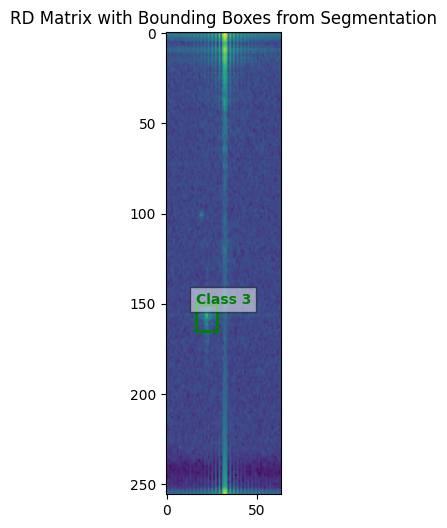

In [74]:
# Compute bounding boxes from the RD segmentation mask
bboxes = create_bounding_boxes(rd_mask, class_colors, min_area=10)

# Plot the last frame of the RD matrix and overlay the bounding boxes
plt.figure(figsize=(8, 6))
plt.imshow(rd_matrix[-1].squeeze(), cmap='viridis')
ax = plt.gca()

# Loop over each class and its corresponding bounding boxes
for class_idx, boxes in bboxes.items():
    for bbox in boxes:
        min_row, min_col, max_row, max_col = bbox
        width = max_col - min_col
        height = max_row - min_row
        # Create a rectangle patch with the class-specific color
        rect = mpatches.Rectangle((min_col, min_row), width, height,
                                  fill=False, edgecolor=class_colors[class_idx], linewidth=2)
        ax.add_patch(rect)
        # Add a text label for the class
        ax.text(min_col, min_row, f'Class {class_idx}', color=class_colors[class_idx],
                fontsize=10, weight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.title('RD Matrix with Bounding Boxes from Segmentation')
plt.show()